In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [106]:
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

In [78]:
df=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [79]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [81]:
df=df.drop(['keyword','location','id'],axis=1)

In [82]:
import re
def text_cleaner(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = re.sub(r'https?://\S+', '', text) # remove URLs
    text = re.sub(r"#", "", text)
    return text

In [83]:
df['text'] = df['text'].apply(text_cleaner)

In [84]:
text=list(df['text'].values)

In [85]:
text[:100]

['our deeds are the reason of this earthquake may allah forgive us all',
 'forest fire near la ronge sask canada',
 'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
 '13000 people receive wildfires evacuation orders in california ',
 'just got sent this photo from ruby alaska as smoke from wildfires pours into a school ',
 'rockyfire update california hwy 20 closed in both directions due to lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas',
 'im on top of the hill and i can see a fire in the woods',
 'theres an emergency evacuation happening now in the building across the street',
 'im afraid that the tornado is coming to our area',
 'three people died from the heat wave so far',
 'haha south tampa is getting flooded hah wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding',
 'raining fl

In [86]:
def text_to_number(text):
    voc_size=6000
    onehot_rep=[one_hot(words,voc_size) for words in text ]
    global sent_length
    sent_length=20
    global embedded_docs
    embedded_docs=pad_sequences(onehot_rep,padding='pre',maxlen=sent_length)
    
    return embedded_docs
text_to_number(text)

array([[   0,    0,    0, ..., 5597,  844, 5765],
       [   0,    0,    0, ..., 2761,  292, 2655],
       [2221, 1093, 4313, ...,   63, 1862, 3472],
       ...,
       [   0,    0,    0, ...,  651, 5709, 4999],
       [   0,  380, 1396, ..., 2719,   29, 5001],
       [   0,    0,    0, ..., 3264, 3714, 5786]], dtype=int32)

In [87]:
X_final=np.array(embedded_docs)
y_final=np.array(df['target'])
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [88]:
embedding_vector_features=60
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [90]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=45)

Epoch 1/20
114/114 [==============================] - 4s 31ms/step - loss: 0.0683 - accuracy: 0.9763 - val_loss: 1.2268 - val_accuracy: 0.7386
Epoch 2/20
114/114 [==============================] - 3s 30ms/step - loss: 0.0547 - accuracy: 0.9798 - val_loss: 1.4393 - val_accuracy: 0.7294
Epoch 3/20
114/114 [==============================] - 4s 36ms/step - loss: 0.0655 - accuracy: 0.9757 - val_loss: 1.3119 - val_accuracy: 0.7421
Epoch 4/20
114/114 [==============================] - 3s 31ms/step - loss: 0.0485 - accuracy: 0.9829 - val_loss: 1.2472 - val_accuracy: 0.7318
Epoch 5/20
114/114 [==============================] - 3s 31ms/step - loss: 0.0434 - accuracy: 0.9847 - val_loss: 1.5679 - val_accuracy: 0.7203
Epoch 6/20
114/114 [==============================] - 3s 30ms/step - loss: 0.0388 - accuracy: 0.9873 - val_loss: 1.4200 - val_accuracy: 0.7330
Epoch 7/20
114/114 [==============================] - 4s 31ms/step - loss: 0.0337 - accuracy: 0.9876 - val_loss: 1.6862 - val_accuracy: 0.7230

In [91]:
y_pred=model.predict(X_test)

In [93]:
y_pred=y_pred.round()

In [107]:
def print_report(model):
    y_pred=model.predict(X_test)
    y_pred=y_pred.round()
    print('OVERALL RESULT')
    print(classification_report(y_test,y_pred))
    print("Accuracy: ",accuracy_score(y_test,y_pred))
    plt.show()

    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='g')
    plt.show()

    fpr,tpr,thresholds=metrics.roc_curve(y_test,y_pred)
    roc_auc=metrics.auc(fpr,tpr)
    display=metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc,estimator_name='ROC curve')
    display.plot()
    plt.show()

OVERALL RESULT
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1446
           1       0.69      0.69      0.69      1067

    accuracy                           0.73      2513
   macro avg       0.73      0.73      0.73      2513
weighted avg       0.74      0.73      0.74      2513

Accuracy:  0.7349781138081973


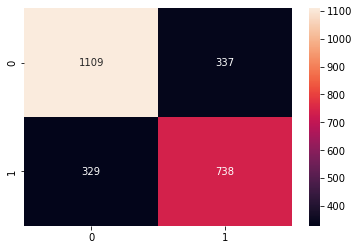

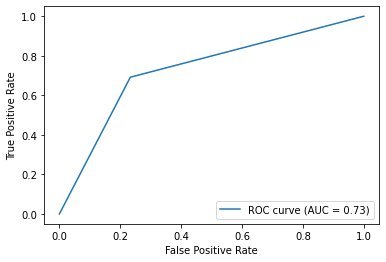

In [108]:
#model with LSTM
print_report(model)

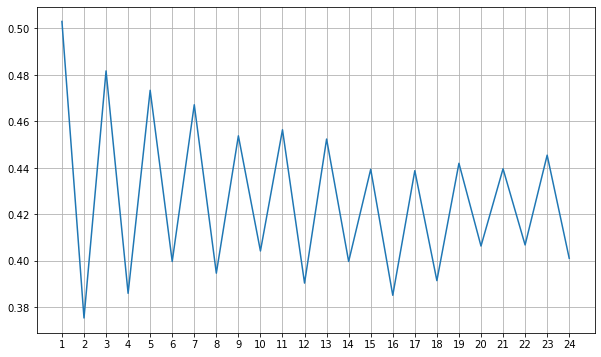

In [110]:
#parameter tuning for KNeighboursClassifier
f1 = []
for k in range(1,25):
    knn_model =KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_predict = knn_model.predict(X_test)
    f1.append(metrics.f1_score(y_test, y_predict))

plt.figure(figsize=(10,6))
plt.plot(range(1,25),f1)
plt.xticks(range(1,25))
plt.grid()
plt.show()

OVERALL RESULT
              precision    recall  f1-score   support

           0       0.61      0.82      0.70      1446
           1       0.54      0.29      0.38      1067

    accuracy                           0.59      2513
   macro avg       0.58      0.55      0.54      2513
weighted avg       0.58      0.59      0.56      2513

Accuracy:  0.5949064862713888


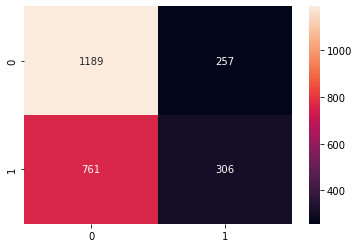

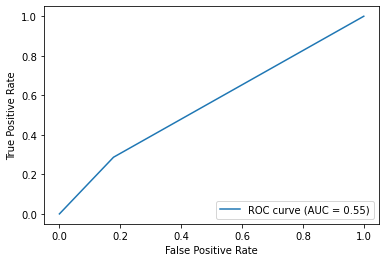

In [113]:
knn_model=KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train,y_train)

print_report(knn_model)

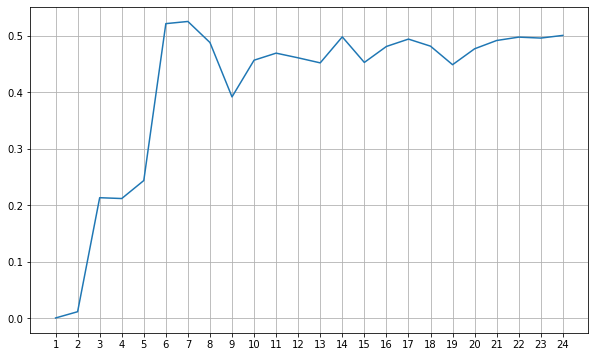

In [115]:
f1 = []
for k in range(1,25):
    dt = tree.DecisionTreeClassifier(max_depth=k)
    dt.fit(X_train, y_train)
    y_predict = dt.predict(X_test)
    f1.append(metrics.f1_score(y_test, y_predict))

plt.figure(figsize=(10,6))
plt.plot(range(1,25),f1)
plt.xticks(range(1,25))
plt.grid()
plt.show()

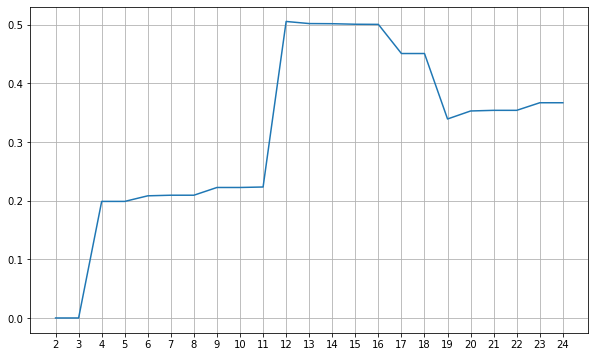

In [116]:
f1 = []
for k in range(2,25):
    dt = tree.DecisionTreeClassifier(max_leaf_nodes=k)
    dt.fit(X_train, y_train)
    y_predict = dt.predict(X_test)
    f1.append(metrics.f1_score(y_test, y_predict))

plt.figure(figsize=(10,6))
plt.plot(range(2,25),f1)
plt.xticks(range(2,25))
plt.grid()
plt.show()
     

OVERALL RESULT
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      1446
           1       0.49      0.52      0.51      1067

    accuracy                           0.57      2513
   macro avg       0.56      0.56      0.56      2513
weighted avg       0.57      0.57      0.57      2513

Accuracy:  0.565857540787903


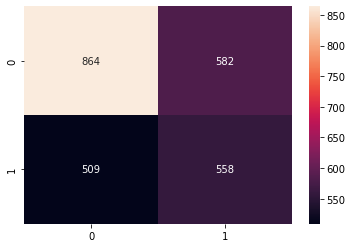

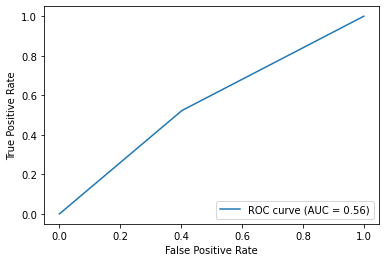

In [118]:
DT_model=tree.DecisionTreeClassifier(max_depth=6,max_leaf_nodes=12)
DT_model.fit(X_train,y_train)
print_report(DT_model)

**As the data is not enough, the accuracy is not high, but this code can be applied for any text classifications. I have seen that LSTM is working pretty well.**